In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit import IBMQ, Aer, transpile
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit.extensions import Initialize

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import QuantumCircuit
from qiskit.tools.monitor import job_monitor

from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit.circuit import QuantumRegister
from qiskit import execute

from numpy import pi

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-education/uni-antioquia-2/quantum-alg',
)

Se crea un vector aleatorio de estado para el circuito

<IPython.core.display.Latex object>

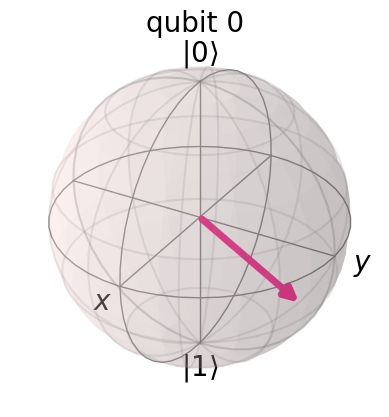

In [8]:
# Crear vector de estado aleatorio
psi = random_statevector(2)

display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

Se transforma el estado en una compuerta de inicialización

In [10]:
# Crear compuerta a partir de vector aleatorio
init_gate = Initialize(psi)
init_gate.label = "init"

Se procede a encontrar una compuerta que tenga un comportamiento inverso al reportado para que cuando el estado es el esperado el resultado sea 0

In [11]:
# Calculo compuerta inicialización inversa
inverse_init_gate = init_gate.gates_to_uncompute()

Se construye un circuito inicial para verificar a partir del estado W la salida del sistema.

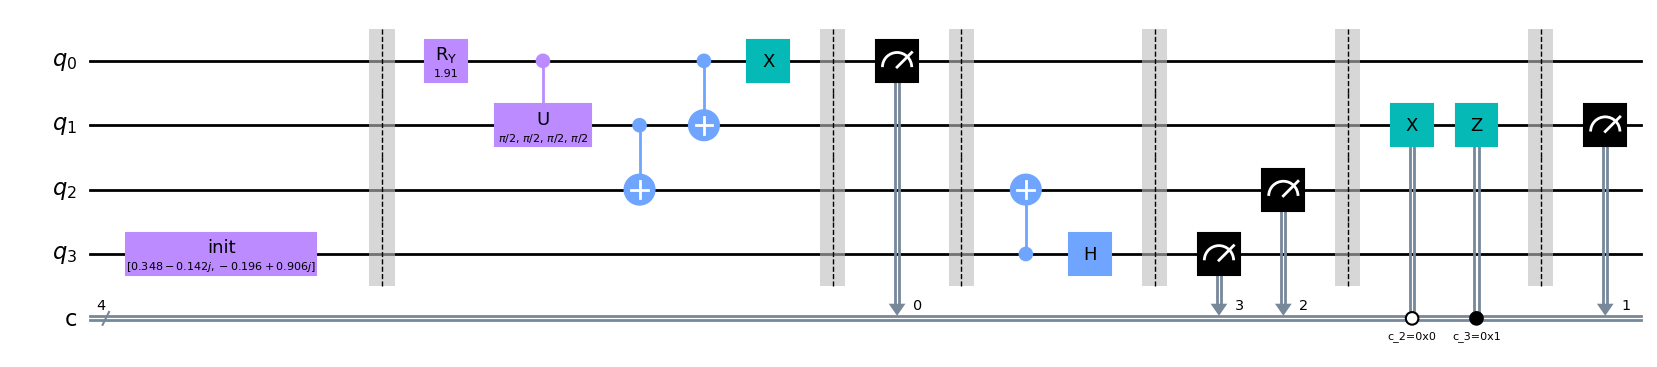

In [73]:
qc = QuantumCircuit(4, 4) # 4 Qubits 3 de entrelazamiento y 1 para teleportar dos bits de medicion para el primer qubit de entrelazamiento y el qubit de teletransporte

# Compuerta de inicialización bit aleatorio
qc.append(init_gate, [3])
qc.barrier()

# Estado W
# Rotación de 2arccos(1/sqrt(3)) https://en.wikipedia.org/wiki/W_state
qc.ry(1.9106332362490184, [0])
qc.cu(pi / 2, pi / 2, pi / 2, pi / 2, [0], [1])
qc.cx([1], [2])
qc.cx([0], [1])
qc.x([0])
qc.barrier()

# Medida qubit 0
qc.measure(0,0)
qc.barrier()

# Circuito para medicion
qc.cnot(3, 2)
qc.h(3)
qc.barrier()

# Medida qubit 2 y 3
qc.measure(3,3)
qc.measure(2,2)
qc.barrier()

# Circuito para teletransportar valores medidos
qc.x(1).c_if(2, 0)
qc.z(1).c_if(3, 1)
qc.barrier()


# Medida del q1
qc.measure(1,1)

# Dibujar el circuito
qc.draw()

Para comprobar si el codigo es correcto, primero sabemos que los posibles estados de salida son los que se muestra a continuación

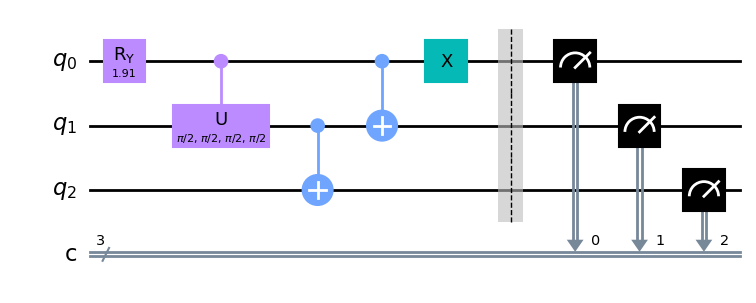

In [74]:
qc_w = QuantumCircuit(3, 3) # 4 Qubits 3 de entrelazamiento y 1 para teleportar dos bits de medicion para el primer qubit de entrelazamiento y el qubit de teletransporte

# Estado W
# Rotación de 2arccos(1/sqrt(3)) https://en.wikipedia.org/wiki/W_state
qc_w.ry(1.9106332362490184, [0])
qc_w.cu(pi / 2, pi / 2, pi / 2, pi / 2, [0], [1])
qc_w.cx([1], [2])
qc_w.cx([0], [1])
qc_w.x([0])
qc_w.barrier()

# Medidas
qc_w.measure(0,0)
qc_w.measure(1,1)
qc_w.measure(2,2)

# Dibujar el circuito
qc_w.draw()

In [75]:
sim = Aer.get_backend('aer_simulator')
t_qc_w = transpile(qc_w, sim)
t_qc_w.save_statevector()
counts = sim.run(t_qc_w).result().get_counts()
counts

{'010': 367, '001': 328, '100': 329}

de la misma forma se puede obtener la distribucción de valores para el circuito final de modificación de los valores obtenidos para el cubit 1, 2 y 3 despues de efectuar el conjunto de compuertas para el estado 1 del cubit 0.

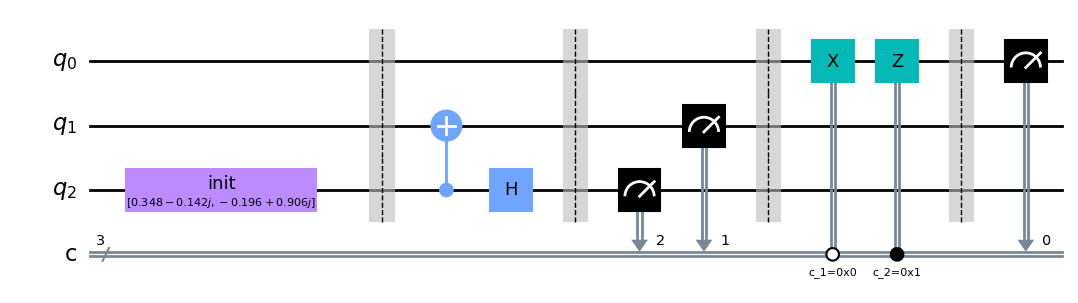

In [76]:
qc_control = QuantumCircuit(3, 3) # 4 Qubits 3 de entrelazamiento y 1 para teleportar dos bits de medicion para el primer qubit de entrelazamiento y el qubit de teletransporte

# Compuerta de inicialización bit aleatorio
qc_control.append(init_gate, [2])
qc_control.barrier()

# Circuito para medicion
qc_control.cnot(2, 1)
qc_control.h(2)
qc_control.barrier()

# Medida qubit 1 y 2
qc_control.measure(2,2)
qc_control.measure(1,1)
qc_control.barrier()

# Circuito para teletransportar valores medidos
qc_control.x(0).c_if(1, 0)
qc_control.z(0).c_if(2, 1)
qc_control.barrier()


# Medida del q0
qc_control.measure(0,0)

# Dibujar el circuito
qc_control.draw()

Se prueba el conteo del circuito obtenido

In [77]:
sim = Aer.get_backend('aer_simulator')
t_qc_control = transpile(qc_control, sim)
t_qc_control.save_statevector()
counts = sim.run(t_qc_control).result().get_counts()
counts

{'001': 63, '101': 78, '010': 407, '110': 476}

Tambien se prueba el estado del circuito cuando el cubit 0 es 1.

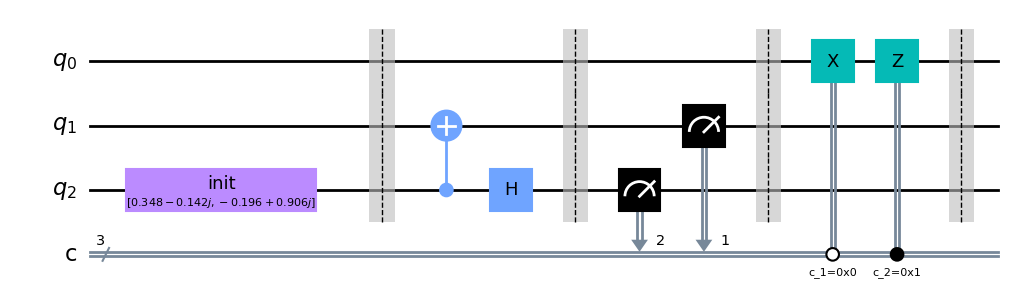

In [78]:
qc_control = QuantumCircuit(3, 3) # 4 Qubits 3 de entrelazamiento y 1 para teleportar dos bits de medicion para el primer qubit de entrelazamiento y el qubit de teletransporte

# Compuerta de inicialización bit aleatorio
qc_control.append(init_gate, [2])
qc_control.barrier()

# Circuito para medicion
qc_control.cnot(2, 1)
qc_control.h(2)
qc_control.barrier()

# Medida qubit 1 y 2
qc_control.measure(2,2)
qc_control.measure(1,1)
qc_control.barrier()

# Circuito para teletransportar valores medidos
qc_control.x(0).c_if(1, 0)
qc_control.z(0).c_if(2, 1)
qc_control.barrier()

# Dibujar el circuito
qc_control.draw()

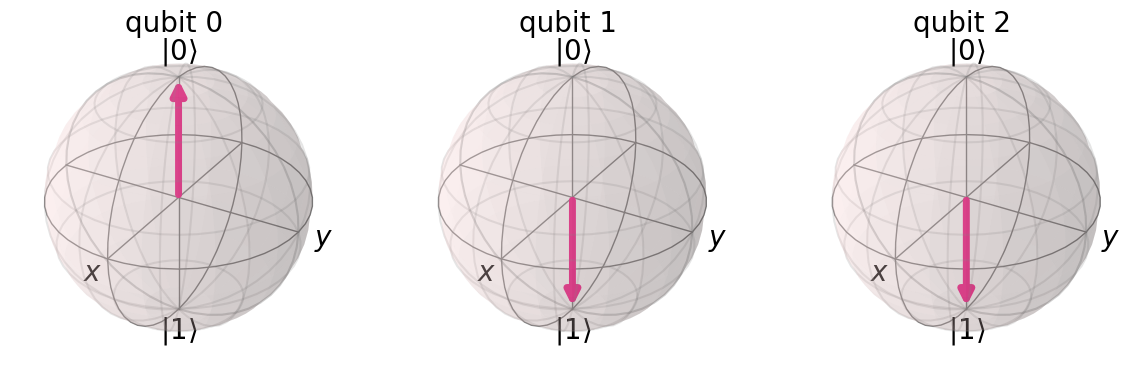

In [79]:
sim = Aer.get_backend('aer_simulator')
t_qc_control = transpile(qc_control, sim)
t_qc_control.save_statevector()
out_vector = sim.run(t_qc_control).result().get_statevector()
plot_bloch_multivector(out_vector)

Teniendo esta información se realiza una simulación a partir del circuito completo

In [80]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
result = sim.run(t_qc).result()
counts = result.get_counts()

In [81]:
counts

{'0100': 16,
 '1011': 22,
 '0011': 25,
 '1010': 140,
 '1100': 26,
 '1000': 25,
 '1110': 174,
 '0101': 147,
 '0110': 139,
 '1101': 145,
 '0000': 27,
 '0010': 138}

Se eliminan las medidas correspondientes al estado 1 para el primer cubit ya que estas no tienen superposición

In [82]:
def eliminar_estado_0(counts):
    for state in list(counts.keys()):
        if state.endswith('1'):
            counts.pop(state)
eliminar_estado_0(counts)

Con estos valores graficamos los estados correspondientes para todos los cubits y el cubit de interes

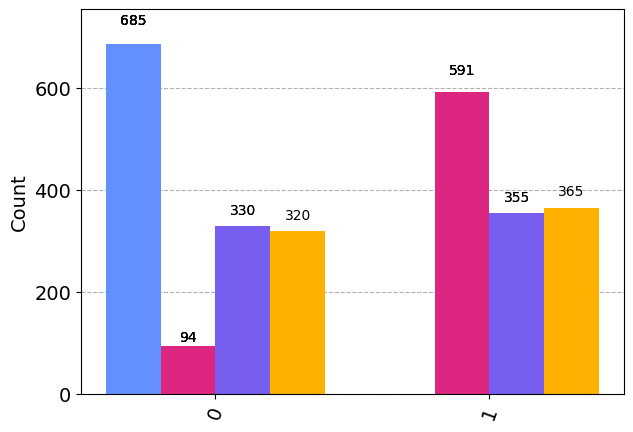

In [83]:
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(4)]
plot_histogram(qubit_counts)

El mismo procedimiento pero unicamente para el cubit de interes

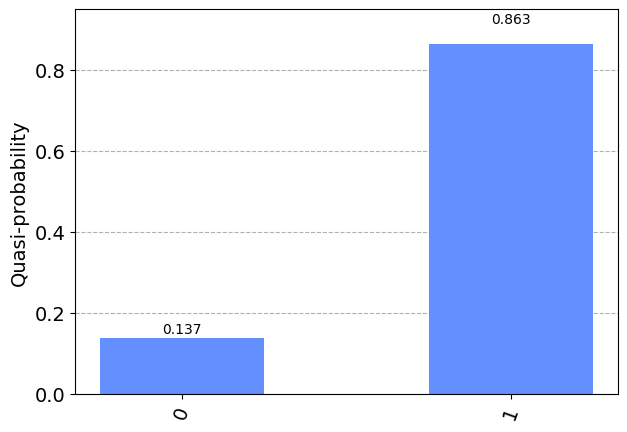

In [84]:
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(1,2)]
plot_distribution(qubit_counts)

Se obtienen las probabilidades del vector de estado para obtener un punto de comparación

In [85]:
# Obtenido de https://qiskit.org/documentation/stubs/qiskit.quantum_info.Statevector.probabilities.html
probs = psi.probabilities()
print('probs: {}'.format(probs))

probs: [0.14081092 0.85918908]


Se puede comprobar que las probabilidades obtenidas para el vector de estado son cercanas obteniendo la medida del error

In [86]:
import numpy as np

def error_l2(real, teoric):
    l2_norm = np.sum(np.power((teoric-real),2))
    l2_norm = np.sqrt(l2_norm)
    print(l2_norm)

In [87]:
total_shots = qubit_counts[0]['0']+qubit_counts[0]['1']
error_l2([qubit_counts[0]['0']/total_shots, qubit_counts[0]['1']/total_shots], probs)

0.00506944606708356


Se puede evidenciar una tasa de error baja en la medición y el estado

Procedemos a graficar la esfera de bloch para los estados

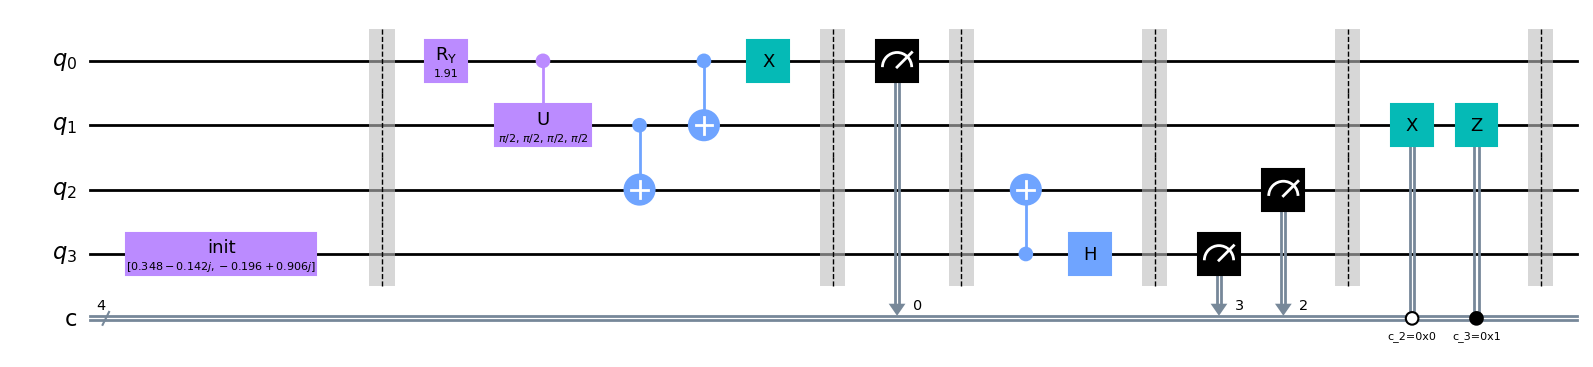

In [88]:
qc = QuantumCircuit(4, 4) # 4 Qubits 3 de entrelazamiento y 1 para teleportar dos bits de medicion para el primer qubit de entrelazamiento y el qubit de teletransporte

# Compuerta de inicialización bit aleatorio
qc.append(init_gate, [3])
qc.barrier()

# Estado W
# Rotación de 2arccos(1/sqrt(3)) https://en.wikipedia.org/wiki/W_state
qc.ry(1.9106332362490184, [0])
qc.cu(pi / 2, pi / 2, pi / 2, pi / 2, [0], [1])
qc.cx([1], [2])
qc.cx([0], [1])
qc.x([0])
qc.barrier()

# Medida qubit 0
qc.measure(0,0)
qc.barrier()

# Circuito para medicion
qc.cnot(3, 2)
qc.h(3)
qc.barrier()

# Medida qubit 2 y 3
qc.measure(3,3)
qc.measure(2,2)
qc.barrier()

# Circuito para teletransportar valores medidos
qc.x(1).c_if(2, 0)
qc.z(1).c_if(3, 1)
qc.barrier()


# Dibujar el circuito
qc.draw()

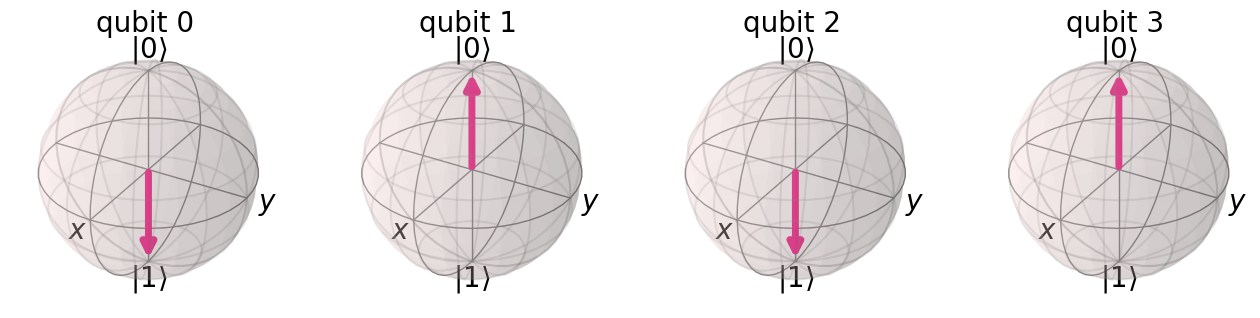

In [89]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
out_vector = sim.run(t_qc).result().get_statevector()
plot_bloch_multivector(out_vector)

Se puede evidenciar un pequeño movimiento asociado al cubit 1 con respecto al reportado pero como se vio con las esferas de blochsphere para el estado del cubit 0 en 1, esto puede deberse al valor que toma esta

# Simulación en hardware real

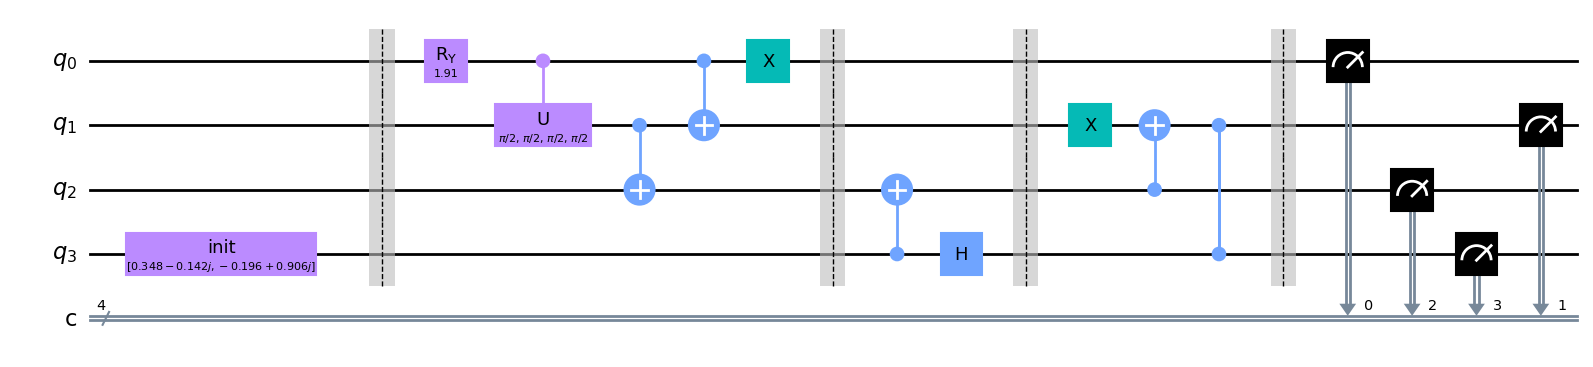

In [90]:
qc = QuantumCircuit(4, 4) # 4 Qubits 3 de entrelazamiento y 1 para teleportar dos bits de medicion para el primer qubit de entrelazamiento y el qubit de teletransporte

# Compuerta de inicialización bit aleatorio
qc.append(init_gate, [3])
qc.barrier()

# Estado W
# Rotación de 2arccos(1/sqrt(3)) https://en.wikipedia.org/wiki/W_state
qc.ry(1.9106332362490184, [0])
qc.cu(pi / 2, pi / 2, pi / 2, pi / 2, [0], [1])
qc.cx([1], [2])
qc.cx([0], [1])
qc.x([0])
qc.barrier()


# Circuito para medicion
qc.cnot(3, 2)
qc.h(3)
qc.barrier()

# Circuito para teletransportar valores medidos
qc.x(1)
qc.cx(2, 1)
qc.cz(3, 1)
qc.barrier()

# Medida de los estados involucrados
qc.measure(0,0)
qc.measure(2,2)
qc.measure(3,3)
qc.measure(1,1)

# Dibujar el circuito
qc.draw()

Prueba del funcionamiento de la simulación

In [91]:
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
counts

{'0100': 23,
 '0011': 32,
 '1011': 24,
 '1100': 23,
 '1000': 22,
 '0110': 129,
 '1101': 139,
 '1010': 151,
 '1110': 139,
 '0101': 156,
 '0000': 20,
 '0010': 166}

Proceso de carga de la cuenta y recursos de computo

In [92]:
IBMQ.load_account()

/tmp/ipykernel_60/485379158.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [93]:
provider = IBMProvider(instance='ibm-q-education/uni-antioquia-2/quantum-alg')

Selección del recurso menos cargado

In [94]:
from qiskit_ibm_provider import least_busy

backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))

Se manda a ejecutar el codigo para el circuito

In [97]:
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_id = job.job_id()
backend_name = job.backend().name
print('Job id: ', job_id)
print('Backend name: ', backend_name)

Job id:  chc8m80fdairicn9r69g
Backend name:  ibmq_manila


# Mitigación de errores

A partir de las librerias dispuestas por qiskit se realiza el proceso de mitigación de errores

In [99]:
qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [101]:
job = execute(meas_calibs, backend=backend, shots=1000)
job_id = job.job_id()
backend_name = job.backend().name
print('Job id: ', job_id)
print('Backend name: ', backend_name)

Job id:  chc8n85v6mngo8n0t330
Backend name:  ibmq_manila


# Recuperación de datos y analisis

In [3]:
provider = IBMProvider(instance='ibm-q-education/uni-antioquia-2/quantum-alg')
job_result = provider.backend.retrieve_job("chc8m80fdairicn9r69g")
job_error = provider.backend.retrieve_job("chc8n85v6mngo8n0t330")

despues de recuperar los datos repetimos el procedimiento para verificar el resultados con respecto al estado estimado

In [4]:
result = job_result.result()
counts = result.get_counts().copy()

In [5]:
counts

{'0000': 154,
 '0001': 18,
 '0010': 575,
 '0011': 111,
 '0100': 153,
 '0101': 533,
 '0110': 438,
 '0111': 20,
 '1000': 140,
 '1001': 24,
 '1010': 556,
 '1011': 153,
 '1100': 189,
 '1101': 480,
 '1110': 443,
 '1111': 13}

In [7]:
def eliminar_estado_0(counts):
    for state in list(counts.keys()):
        if state.endswith('1'):
            counts.pop(state)

In [8]:
eliminar_estado_0(counts)

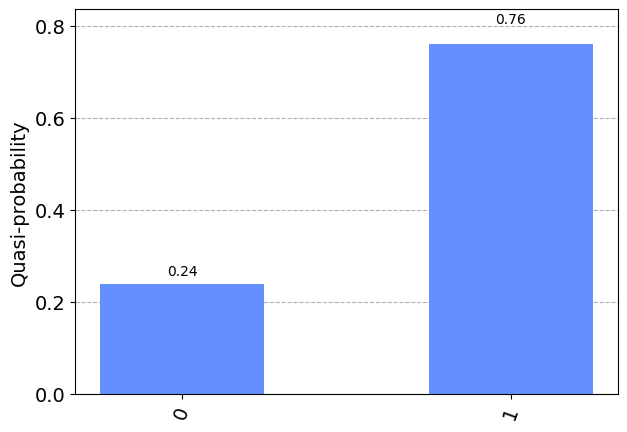

In [9]:
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(1,2)]
plot_distribution(qubit_counts)

Calculamos el error nuevamente

In [11]:
import numpy as np

def error_l2(real, teoric):
    l2_norm = np.sum(np.power((teoric-real),2))
    l2_norm = np.sqrt(l2_norm)
    print(l2_norm)

In [14]:
#recuperar vector de probabilidades
probs = np.asarray([0.14081092, 0.85918908])

In [15]:
total_shots = qubit_counts[0]['0']+qubit_counts[0]['1']
error_l2([qubit_counts[0]['0']/total_shots, qubit_counts[0]['1']/total_shots], probs)

0.1405308950869184


Vemos que en general el comportamiento se mantiene pero con mayor error, se procede a realizar correción de errores

In [16]:
cal_results = job_error.result()

In [18]:
qr = QuantumRegister(4)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [19]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.93  0.109 0.023 0.001 0.038 0.002 0.002 0.    0.031 0.001 0.    0.
  0.002 0.    0.    0.   ]
 [0.01  0.857 0.001 0.028 0.    0.027 0.    0.001 0.001 0.022 0.    0.001
  0.    0.003 0.    0.   ]
 [0.042 0.004 0.936 0.095 0.004 0.    0.031 0.001 0.002 0.    0.023 0.002
  0.    0.    0.002 0.   ]
 [0.003 0.008 0.023 0.855 0.    0.    0.    0.043 0.    0.    0.    0.023
  0.    0.    0.    0.001]
 [0.008 0.    0.    0.    0.908 0.1   0.027 0.009 0.001 0.    0.    0.
  0.02  0.003 0.003 0.   ]
 [0.    0.004 0.    0.    0.013 0.847 0.    0.013 0.    0.    0.    0.
  0.    0.023 0.    0.   ]
 [0.001 0.    0.004 0.002 0.028 0.    0.909 0.088 0.    0.    0.001 0.
  0.    0.    0.016 0.002]
 [0.    0.    0.001 0.011 0.001 0.016 0.021 0.833 0.    0.    0.    0.
  0.    0.003 0.    0.025]
 [0.006 0.003 0.001 0.    0.    0.    0.    0.    0.903 0.088 0.03  0.005
  0.026 0.003 0.001 0.001]
 [0.    0.015 0.    0.001 0.    0.    0.    0.    0.021 0.874 0.    0.022
  0.    0.022 0.    0.004]
 [0. 

In [20]:
meas_filter = meas_fitter.filter
noisy_counts = cal_results.get_counts(0)
print(noisy_counts)

{'0000': 930, '0001': 10, '0010': 42, '0011': 3, '0100': 8, '0110': 1, '1000': 6}


In [21]:
mitigated_results = meas_filter.apply(cal_results)
mitigated_counts = mitigated_results.get_counts(0)
print(mitigated_counts)

{'0000': 999.9999999892228, '0011': 1.0469080637121042e-09, '0101': 1.2063213587765187e-09, '0110': 1.1625163054418408e-09, '0111': 1.2912551739657774e-09, '1000': 1.7310680319737592e-10, '1001': 1.2479373090457102e-09, '1010': 1.2656042186476313e-09, '1011': 1.2965573684131648e-09, '1100': 1.2332208032539427e-09, '1101': 1.3016225597350939e-09, '1110': 1.2997963955152514e-09, '1111': 1.3025037264025041e-09}


Observamos el resultado de la mitigación de errores para el estado 0

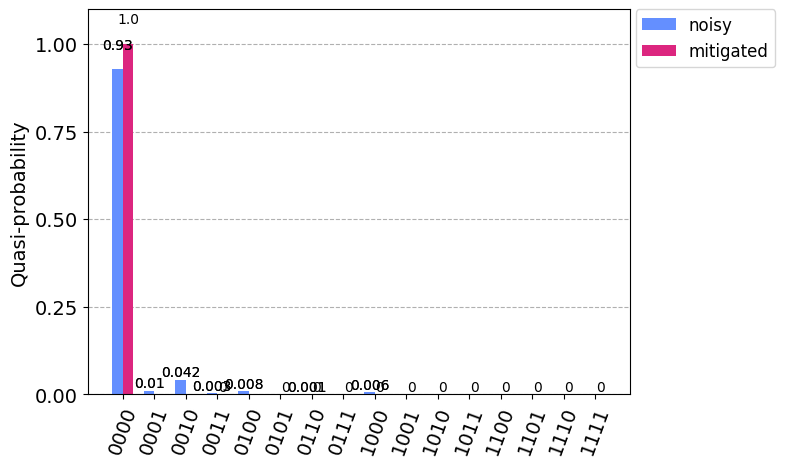

In [22]:
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

Realizamos el mismo procedimiento pero para los resultados obtenidos de la medición obteniendo los siguientes datos

In [23]:
mitigated_results = meas_filter.apply(result)
mitigated_counts = mitigated_results.get_counts()
print(mitigated_counts)

{'0000': 140.54952768065914, '0010': 565.0547776802433, '0011': 108.44896275095176, '0100': 78.59881454125868, '0101': 611.5888928343155, '0110': 466.59056539974557, '1000': 126.38419616164734, '1001': 4.919058854750314, '1010': 556.8100196388602, '1011': 166.07688182940447, '1100': 136.9563711005753, '1101': 561.2702904602195, '1110': 476.7516410673691}


In [25]:
exp_counts = result.get_counts()

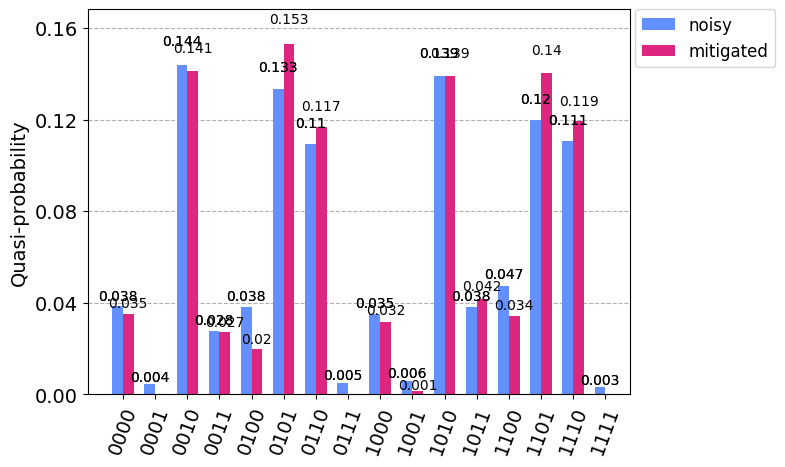

In [26]:
plot_histogram([exp_counts, mitigated_counts], legend=['noisy', 'mitigated'])

Repetimos el procedimiento para los datos mitigados

In [27]:
eliminar_estado_0(mitigated_counts)

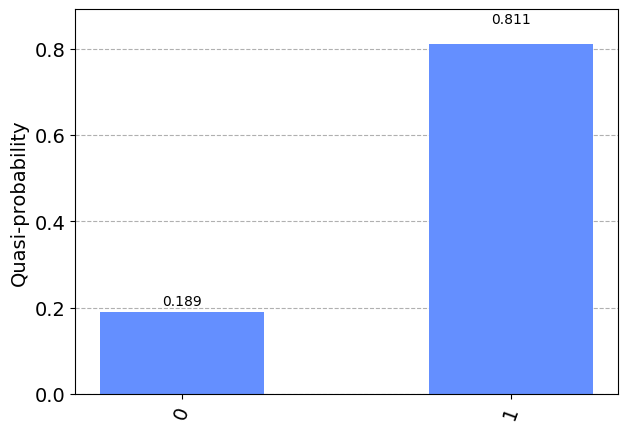

In [29]:
qubit_counts = [marginal_counts(mitigated_counts, [qubit]) for qubit in range(1,2)]
plot_distribution(qubit_counts)

In [30]:
total_shots = qubit_counts[0]['0']+qubit_counts[0]['1']
error_l2([qubit_counts[0]['0']/total_shots, qubit_counts[0]['1']/total_shots], probs)

0.06869052511626994


Vemos que el procedimiento de mitigación de errores fue efectivo ya que se redujo a la mitad el error L2 asociado para el estado esperado